<center><img src="https://i.imgur.com/20rO1id.jpg" width="500px"></center>

# Introduction

Hello everyone! Weclome to the "Prostate cANcer graDe Assessment (PANDA) Challenge" competition on Kaggle! In this competition, contestants are challenged to build machine learning models to diagnose Prostate Cancer from biopsy scans (images and masks). This problem is important because fast and accurate automated diagnosis can help reduce burden on doctors and let them focus on curing patients.

In this kernel, I will show how one can build a **multitask model** to solve this problem. I will build a ResNet-based model, which takes a biopsy scan as input and predicts two quantities: the **ISUP grade and  Gleason score**. These are two different, bu related scales used to measure the severity of Prostate Cancer. Training a model on two different, but related tasks **can improve the model's performance on both tasks. This is the magic of multitask learning!**

I will make use of all 8 cores on the TPU v3-8 to train an 8-fold model in less than 1 hour :D


<center><img src="https://i.imgur.com/piOxK6F.png" width="750px"></center>

# Acknowledgements

1. [PyTorch XLA ~ by PyTorch](https://pytorch.org/xla/release/1.5/index.html)
2. [Torchvision Models ~ by PyTorch](https://pytorch.org/docs/stable/torchvision/models.html)
3. [PANDA / submit test ~ Yasufumi Nakama](https://www.kaggle.com/yasufuminakama/panda-submit-test)
4. [Super-duper fast pytorch tpu kernel... ~ by Abhishek](https://www.kaggle.com/abhishek/super-duper-fast-pytorch-tpu-kernel)

# Contents

* [Preparing the ground](#1)
    * [Set up PyTorch-XLA](#1.1)
    * [Import libraries](#1.2)
    * [Set hyperparameters and paths](#1.3)
    * [Load .csv data](#1.4)
    * [Convert Gleason scores to list format](#1.5)
    * [Display few images](#1.6)

    
* [Modeling](#2)
    * [Build PyTorch dataset](#2.1)
    * [Build ResNet model](#2.2)
    * [Visualize ResNet architecture](#2.3)
    * [Split train.csv into 8 folds](#2.4)
    * [Define cross entropy and accuracy](#2.5)
    * [Define custom PANDA loss for multitask model](#2.6)
    * [Define helper function for training logs](#2.7)
    * [Train model on all 8 TPU cores in parallel](#2.8)


* [Takeaways](#3)

# Preparing the ground

## Set up PyTorch-XLA (inspired by Abhishek's kernel :D)

In [1]:
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev
!export XLA_USE_BF16=1
!pip install -q torchviz

## Import libraries (for data loading, processing, and modeling on TPU)

In [2]:
import os
import gc
import cv2
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from skimage.io import MultiImage
from joblib import Parallel, delayed

from sklearn.utils import shuffle
from colorama import Fore, Back, Style
from keras.utils import to_categorical as cat

import torch
import torch.nn as nn
from torch.optim import Adam
from torch import LongTensor as LongTensor
from torch import FloatTensor as FloatTensor

import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp

from torchviz import make_dot
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models import resnet18, densenet121, mobilenet_v2
from albumentations import RandomRotate90, Flip, Compose, Normalize, RandomResizedCrop

Using TensorFlow backend.


In [3]:
np.random.seed(42)
torch.manual_seed(42)

## Set hyperparamerters and paths (adjust these to improve CV and LB :D)

In [4]:
FOLDS = 8
EPOCHS = 4

RRC = 1.0
FLIP = 1.0
NORM = 1.0
ROTATE = 1.0
LR = (1e-4, 1e-3)
MODEL_SAVE_PATH = "resnet_model"

WIDTH = 512
HEIGHT = 512
BATCH_SIZE = 128
VAL_BATCH_SIZE = 128
DATA_PATH = '../input/prostate-cancer-grade-assessment/'
RESIZED_PATH = '../input/panda-resized-train-data-512x512/train_images/'

In [5]:
TEST_DATA_PATH = DATA_PATH + 'test.csv'
TRAIN_DATA_PATH = DATA_PATH + 'train.csv'
TEST_IMG_PATH = DATA_PATH + 'test_images/'
TRAIN_IMG_PATH = RESIZED_PATH + 'train_images/'
SAMPLE_SUB_PATH = DATA_PATH + 'sample_submission.csv'

## Load .csv data

In [6]:
test_df = pd.read_csv(TEST_DATA_PATH)
train_df = pd.read_csv(TRAIN_DATA_PATH)
sample_submission = pd.read_csv(SAMPLE_SUB_PATH)

## Convert Gleason scores to list format (to add them as targets for ResNet)

In [7]:
gleason_replace_dict = {0:0, 1:1, 3:2, 4:3, 5:4}

def process_gleason(gleason):
    if gleason == 'negative': gs = (1, 1)
    else: gs = tuple(gleason.split('+'))
    return [gleason_replace_dict[int(g)] for g in gs]

train_df.gleason_score = train_df.gleason_score.apply(process_gleason)

In [8]:
train_df.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,"[0, 0]"
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,"[0, 0]"
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,"[3, 3]"
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,"[3, 3]"
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,"[0, 0]"


In [9]:
test_df.head()

,image_id,data_provider
0,005700be7e06878e6605e7a5a39de1b2,radboud
1,005c6e8877caf724c600fdce5d417d40,karolinska
2,0104f76634ff89bfff1ef0804a95c380,radboud


## Display few images (from train_images directory)

In [10]:
def display_images(num):
    sq_num = np.sqrt(num)
    assert sq_num == int(sq_num)

    sq_num = int(sq_num)
    fig, ax = plt.subplots(nrows=sq_num, ncols=sq_num, figsize=(20, 20))

    for i in range(int(sq_num)):
        for j in range(int(sq_num)):
            idx = i*sq_num + j
            path = TRAIN_IMG_PATH + train_df.image_id[idx]
    
            path += '.png'
            ax[i, j].imshow(cv2.imread(path))
            ax[i, j].set_title('Image {}'.format(idx), fontsize=12)

    plt.show()

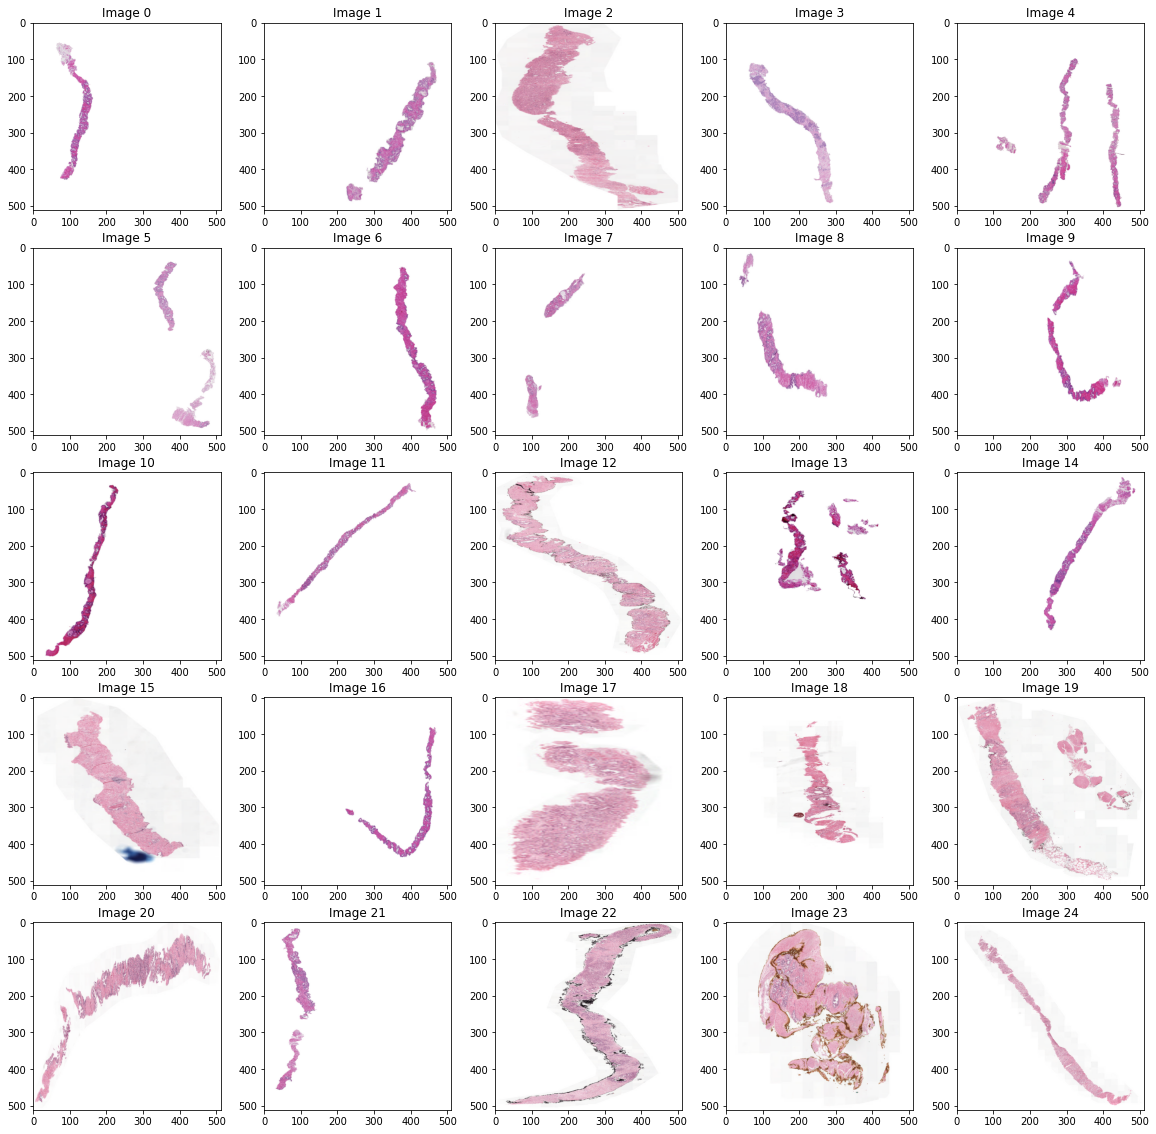

In [11]:
display_images(25)

# Modeling <a id="2"></a>

## Build PyTorch dataset (with image transforms and multi-target)

In [12]:
class PANDADataset(Dataset):
    def __init__(self, data, img_path, is_val=False, is_train=False):

        self.data = data
        self.is_val = is_val
        self.is_train = is_train
        self.image_path = img_path
        self.image_id = data.image_id
        self.aug = self.norm = Normalize(p=NORM)

        if is_train or is_val:
            self.isup_grade = data.isup_grade
            self.gleason_score = data.gleason_score

            if is_train:
                self.flip = Flip(p=FLIP)
                self.rotate = RandomRotate90(p=ROTATE)
                self.crop = RandomResizedCrop(p=RRC, width=WIDTH, height=HEIGHT)
                self.aug = Compose([self.flip, self.rotate, self.crop, self.norm], p=1)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        path = self.image_path + self.image_id[idx]

        if self.is_train or self.is_val:
            path += '.png'
            image = cv2.imread(path)
        else:
            path += '.tiff'
            image = MultiImage(path)[-1]
            image = cv2.resize(image, (HEIGHT, WIDTH))

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.aug(image=image)['image'].reshape((3, HEIGHT, WIDTH))
        
        if self.is_train or self.is_val:
            isup_grade = cat([self.data.isup_grade[idx]], num_classes=6)
            gleason_0 = cat([self.data.gleason_score[idx][0]], num_classes=5)
            gleason_1 = cat([self.data.gleason_score[idx][1]], num_classes=5)
            target = np.concatenate([isup_grade, gleason_0, gleason_1], axis=1)
            
        if self.is_train or self.is_val:
            return FloatTensor(image), FloatTensor(target)
        else:
            return FloatTensor(image)

## Build ResNet model (with 3 dense heads for 3 targets)

In [13]:
class ResNetDetector(nn.Module):
    def __init__(self):
        super(ResNetDetector, self).__init__()

        self.softmax = nn.Softmax(dim=1)
        self.dense_1 = nn.Linear(512, 6)
        self.dense_2 = nn.Linear(512, 5)
        self.dense_3 = nn.Linear(512, 5)
        self.resnet = resnet18(pretrained=True)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])
        
    def forward(self, img):
        feat = self.resnet(img).squeeze()

        isup_logit = self.dense_1(feat)
        gleason_logit_0 = self.dense_2(feat)
        gleason_logit_1 = self.dense_3(feat)
        
        isup_prob = self.softmax(isup_logit)
        gleason_prob_0 = self.softmax(gleason_logit_0)
        gleason_prob_1 = self.softmax(gleason_logit_1)
        return torch.cat([isup_prob, gleason_prob_0, gleason_prob_1], axis=1)

## Visualize ResNet architecture (with pytorchviz)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


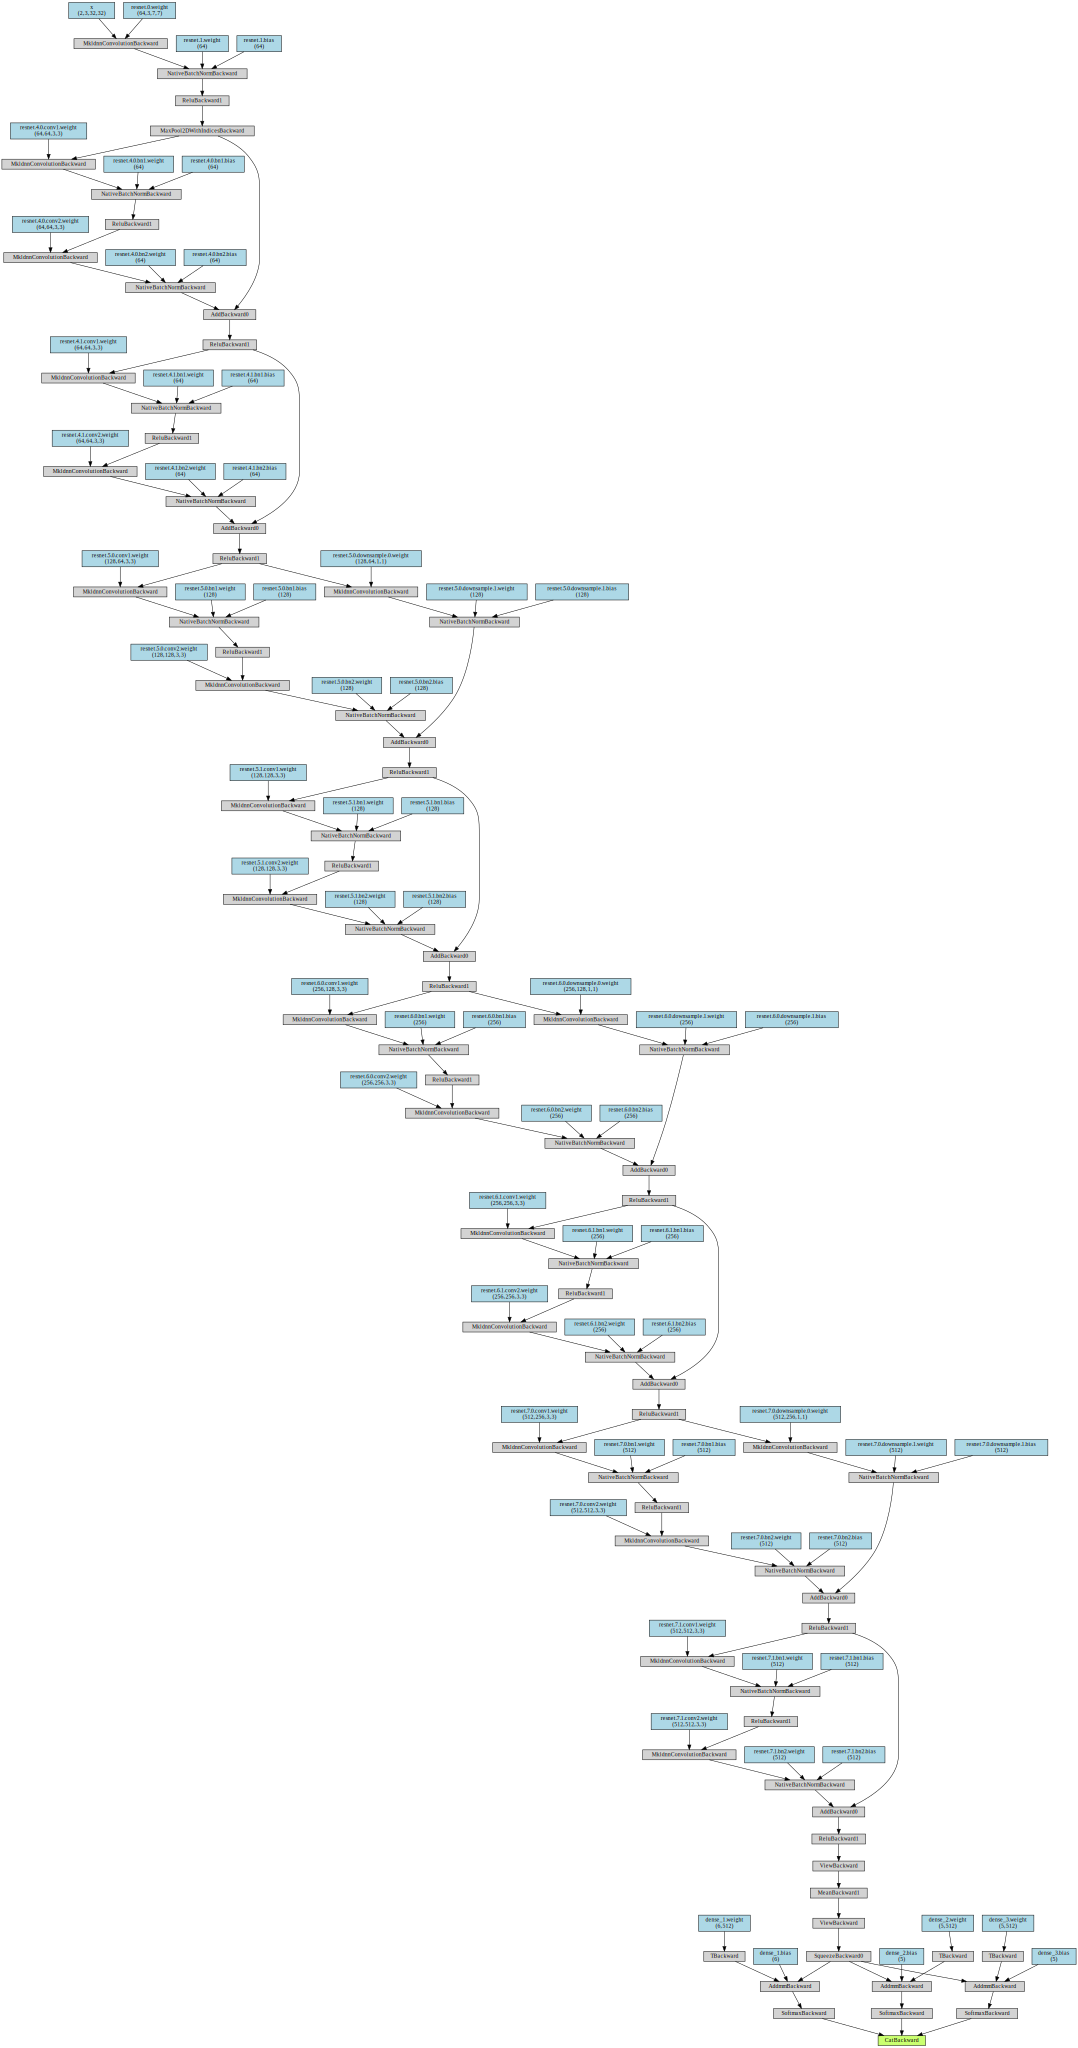

In [14]:
model = ResNetDetector()
x = torch.randn(2, 3, 32, 32).requires_grad_(True)
y = model(x)
make_dot(y, params=dict(list(model.named_parameters()) + [('x', x)]))

In [15]:
del model, x, y
gc.collect()

55187

## Split train.csv into 8 folds (for cross-validation)

In [16]:
val_sets, train_sets = [], []
val_splits = np.int32((np.arange(FOLDS + 1)/FOLDS) * len(train_df))
val_indices = [[val_splits[i], val_splits[i+1]] for i in range(FOLDS)]

for fold in tqdm(range(FOLDS)):
    val_idx = val_indices[fold]
    if fold == FOLDS - 1: val_idx[1] -= 1
    val_sets.append(train_df[val_idx[0]:val_idx[1]])
    train_sets.append(pd.concat([train_df[:val_idx[0]], train_df[val_idx[1]:]]))

## Define cross entropy and accuracy (for backpropagation)

In [17]:
def cel(inp, targ):
    _, labels = targ.max(dim=1)
    return nn.CrossEntropyLoss()(inp, labels)

def acc(inp, targ):
    inp_idx = inp.max(axis=1).indices
    targ_idx = targ.max(axis=1).indices
    return (inp_idx == targ_idx).float().sum(axis=0)/len(inp_idx)

## Define custom PANDA loss for multitask model (combining CEL for all three targets)

In [18]:
def panda_cel(inp, targ):
    isup_loss = cel(inp[:, :6], targ[:, :6])
    gleason_loss_0 = cel(inp[:, 6:11], targ[:, 6:11])
    gleason_loss_1 = cel(inp[:, 11:16], targ[:, 11:16])
    return [isup_loss, gleason_loss_0, gleason_loss_1],\
           isup_loss + gleason_loss_0 + gleason_loss_1

def panda_acc(inp, targ):
    isup_accuracy = acc(inp[:, :6], targ[:, :6])
    gleason_accuracy_0 = acc(inp[:, 6:11], targ[:, 6:11])
    gleason_accuracy_1 = acc(inp[:, 11:16], targ[:, 11:16])
    return [isup_accuracy, gleason_accuracy_0, gleason_accuracy_1]

## Define helper function for training logs (to check training status)

In [19]:
def print_metric(data, fold, start, end, metric, typ):
    r = Fore.RESET
    n = ["ISUP", "G-0", "G-1"]
    time = np.round(end - start, 1)
    time = "Time: {} s".format(time)
    c = [Fore.CYAN, Fore.YELLOW, Fore.MAGENTA]
    
    tick = Fore.GREEN + '\u2714' + Fore.RESET
    prefix = "FOLD {} ".format(fold + 1) + tick + "  "
    
    string = prefix
    for idx in range(3):
        value = np.round(data[idx].item(), 3)
        t = typ, n[idx], metric, c[idx], value, Fore.RESET
        string = string + "{} {} {}: {}{}{}".format(*t) + "  "
        
    print(string + time)

## Train model on all 8 TPU cores in parallel (one fold per core)

In [20]:
def train(fold):
    val = val_sets[fold]
    train = train_sets[fold]
    device = xm.xla_device(fold + 1)
    
    def xla(tensor):
        return tensor.to(device)
   
    val = val.reset_index(drop=True)
    val_set = PANDADataset(val, TRAIN_IMG_PATH, is_val=True)
    val_loader = DataLoader(val_set, batch_size=VAL_BATCH_SIZE)

    train = train.reset_index(drop=True)
    train_set = PANDADataset(train, TRAIN_IMG_PATH, is_train=True)
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

    network = xla(ResNetDetector())
    optimizer = Adam([{'params': network.resnet.parameters(), 'lr': LR[0]},
                      {'params': network.dense_1.parameters(), 'lr': LR[1]},
                      {'params': network.dense_2.parameters(), 'lr': LR[1]},
                      {'params': network.dense_3.parameters(), 'lr': LR[1]}])

    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5,
                                  patience=2, verbose=True, eps=1e-6)

    start = time.time()
    for epoch in range(EPOCHS):
        batch = 1
        for train_batch in train_loader:
            train_img, train_targs = train_batch

            network = xla(network)
            train_img = xla(train_img)
            train_targs = xla(train_targs)
            
            network.train()
            train_preds = network.forward(train_img)
            train_acc = panda_acc(train_preds, train_targs.squeeze())
            train_loss, total_loss = panda_cel(train_preds, train_targs.squeeze())

            optimizer.zero_grad()
            total_loss.backward()
            xm.optimizer_step(optimizer, barrier=True)

            batch = batch + 1
           
        network.eval()
        for val_batch in val_loader:
            img, targ = val_batch
            val_preds, val_targs = [], []

            with torch.no_grad():
                img = xla(img)
                network = xla(network)
                pred = network.forward(img)
                val_preds.append(pred); val_targs.append(targ)
        
        val_preds = torch.cat(val_preds, axis=0)
        val_targs = torch.cat(val_targs, axis=0)
        
        val_targs = xla(val_targs)
        val_acc = panda_acc(val_preds, val_targs.squeeze())
        val_loss, _ = panda_cel(val_preds, val_targs.squeeze())
       
        scheduler.step(val_loss[0])
       
    end = time.time()
    print_metric(val_acc, fold, start, end, metric="acc", typ="Val")
    torch.save(network.state_dict(), MODEL_SAVE_PATH + "_" + str(fold + 1) + ".pt")

In [21]:
Parallel(n_jobs=FOLDS, backend="threading")(delayed(train)(i) for i in range(FOLDS))

FOLD 4 ✔  Val ISUP acc: 0.468  Val G-0 acc: 0.532  Val G-1 acc: 0.426  Time: 3094.9 s
FOLD 5 ✔  Val ISUP acc: 0.468  Val G-0 acc: 0.404  Val G-1 acc: 0.383  Time: 3100.8 s
FOLD 8 ✔  Val ISUP acc: 0.478  Val G-0 acc: 0.609  Val G-1 acc: 0.565  Time: 3109.5 s
FOLD 1 ✔  Val ISUP acc: 0.404  Val G-0 acc: 0.532  Val G-1 acc: 0.511  Time: 3122.6 s
FOLD 6 ✔  Val ISUP acc: 0.362  Val G-0 acc: 0.532  Val G-1 acc: 0.617  Time: 3192.0 s
FOLD 3 ✔  Val ISUP acc: 0.362  Val G-0 acc: 0.511  Val G-1 acc: 0.489  Time: 3193.4 s
FOLD 7 ✔  Val ISUP acc: 0.447  Val G-0 acc: 0.34  Val G-1 acc: 0.426  Time: 3197.7 s
FOLD 2 ✔  Val ISUP acc: 0.362  Val G-0 acc: 0.34  Val G-1 acc: 0.426  Time: 3202.5 s


[None, None, None, None, None, None, None, None]

# Takeaways <a id="3"></a>

1. Using all 8 TPU cores in parallel can dramatically speed up KFold training.
2. Using more complex models (like ResNet-152, DenseNet-201, Efficient-B7, etc) can improve the model's performance.
3. Separate kernels should be used for training and inference to take full advantage of the TPU for training and GPU for inference.